### To Get PayPal Data
For this script to be accurate up to and including the month you are reporting on, you must download some data from the PayPal website (https://www.paypal.com/signin).

1. Sign-in
2. Navigate to Reports > Activity Download
3. Change "Transaction Type" from "Balance Affecting" to "All Transactions"
4. For the date range, if you are reporting on, say, Jan 2019, you would start at 01/01/2019 and end at 02/05/2019, in other words you want data for the month you are reporting on PLUS a few days of the following month. This is to account for the settlement period of orders placed at the end of the month you are reporting on.
5. Click "Create Report"
6. Hit the "Refresh" button next to the generating report (don't refresh the actual webpage)
7. Download it and put it with the rest of the statements which are found at Scripts/Fake Folder/Finance/Recurring/PayPal Monthly Audit/CSVs/Monthly CSV Statements. Be sure and change the format of the file name to match the previous files.
8. Run the report

### Report Output
The report will be written to here: Scripts/Fake Folder/Finance/Recurring/PayPal Monthly Audit/Docs/Monthly Reports

### About the PDF report
Sometimes the PDF report will generate and have strange line breaks. If this happens, just rereun the single cell towards the end of this script, under the section header titled "PDF Start".

### Change this stuff

In [1]:
# choose an end date which is the last day that you are reporting on, and go back one year
date_start = '2018-05-01'
date_end = '2019-05-31'

# do you want to run the script AND generate the PDF report? or just run the script?
# the script will run regardless of what you choose here
# choose "yes" or "no"
write_pdf = 'yes'

### Now click Cell > Run All to run the entire script

### Libraries

In [2]:
import os
tilde = os.path.expanduser('~')

import sys
sys.path.insert(0, tilde + '/Scripts/Fake Folder/Python Libraries')

from jb_libraries import *
%matplotlib inline

### Script settings

In [3]:
report_dict = {}

In [4]:
ym = pd.DataFrame({'year and month':pd.date_range(date_start, date_end, freq = 'MS')})
ym['year and month'] = [str(x)[:7] for x in ym['year and month']]
ym.set_index('year and month', inplace = True)

pretty_dates = [calendar.month_abbr[int(str(x)[5:7])] + '\n' + str(x)[:4] for x in ym.index]

csv_path = tilde + '/Scripts/Fake Folder/Finance/Recurring/PayPal Monthly Audit/CSVs/Monthly CSV Statements/'

image_path = tilde + '/Scripts/Fake Folder/Finance/Recurring/PayPal Monthly Audit/Images/'

html_path = tilde + '/Scripts/Fake Folder/Finance/Recurring/PayPal Monthly Audit/HTML/'
html_title = 'PayPal Monthly Audit.html'

style_sheet_path = tilde + '/Scripts/Fake Folder/CSS Stylesheets/Recurring Reports Stylesheet.css'

pdf_path = tilde + '/Scripts/Fake Folder/Finance/Recurring/PayPal Monthly Audit/Docs/Monthly Reports/'

now_pretty = str(dt.datetime.now().date())

### Chart settings

In [5]:
colors = ['#0c2577',
          '#4a7184',
          '#8592bb',
          '#06123b']

fc = '#dfe3ee'

#plt.rcdefaults()
#plt.rcParams.keys()

plt.rcParams['lines.linewidth'] = 5
plt.rcParams['legend.fontsize'] = 20

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif'] = 'Arial'

plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.titleweight'] = 'bold'

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.labelweight'] = 'bold'

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

### View payment module codes

In [6]:
pd.read_sql(
'''
SELECT
DISTINCT payment_module_code
FROM orders
ORDER BY payment_module_code
''', db)

,payment_module_code
0,adabox_subscribe
1,authorizenet
2,authorizenet_aim
3,authorizenet_cim
4,bitpay
5,googlecheckout
6,GV/DC
7,gwib
8,lapwa
9,moneyorder


### Note that we no longer use this table

In [7]:
pd.read_sql(
'''
SELECT
MIN(DATE(date_purchased)),
MAX(DATE(date_purchased))
FROM orders
WHERE payment_module_code = 'paypal'
''', db)

,MIN(DATE(date_purchased)),MAX(DATE(date_purchased))
0,2005-10-12,2009-08-08


### We use this table now

In [8]:
pd.read_sql(
'''
SELECT
MIN(DATE(date_purchased)),
MAX(DATE(date_purchased))
FROM orders
WHERE payment_module_code = 'paypalwpp'
''', db)

,MIN(DATE(date_purchased)),MAX(DATE(date_purchased))
0,2009-08-09,2019-06-21


### Get orders data

In [9]:
os = pd.read_sql(
'''
SELECT
orders_status_id,
orders_status_name
FROM orders_status
''', db)

bs = pd.read_sql(
'''
SELECT
bs_status_id,
bs_status_name
FROM billing_status
''',db)

o_main = pd.read_sql(
'''
SELECT
DATE(date_purchased) AS date_purchased,
orders_id,
order_total AS db_order_total,
orders_status,
orders_billing_status,
'no' AS 'deleted'
FROM orders
WHERE payment_module_code IN ('paypalwpp','paypal')
''', db)

od_main = pd.read_sql(
'''
SELECT
DATE(date_purchased) AS date_purchased,
orders_id,
order_total AS db_order_total,
orders_status,
orders_billing_status,
'yes' AS 'deleted'
FROM orders_deleted od
WHERE od.payment_module_code IN ('paypalwpp','paypal')
''', db)

for df in [os, bs, o_main, od_main]:
    col_fix(df)

### Structure it

In [10]:
# make one dataframe    
orders_main = pd.concat([o_main, od_main], sort = True)
orders_main.reset_index(drop = True, inplace = True)

orders_main['date purchased'] = pd.to_datetime(orders_main['date purchased'])
orders_main['year and month purchased'] = [str(x)[:7] for x in orders_main['date purchased']]

orders_main['orders status name'] = orders_main['orders status'].map(dict(zip(os['orders status id'], os['orders status name'])))
orders_main['billing status name'] = orders_main['orders billing status'].map(dict(zip(bs['bs status id'], bs['bs status name'])))

for col in ['orders status','orders billing status']:
    orders_main.drop(col, 1, inplace = True)
    
for col in ['orders status name','billing status name']:
    orders_main[col] = [x.lower() for x in orders_main[col]]

# get dupes
dupes = orders_main[orders_main['orders id'].duplicated()]
print('%i oid dupe(s)\ndrop them' % len(dupes))

# store and drop them
orders_main_dupes = orders_main[orders_main['orders id'].isin(dupes['orders id'].tolist())].sort_values('orders id')
orders_main.drop_duplicates('orders id', inplace = True)

9 oid dupe(s)
drop them


### Get PayPal data

In [11]:
pp_super_main = pd.read_sql(
'''
SELECT
# subtract 4 hours from this datetime to convert it into PST time
DATE(DATE_SUB(payment_date, INTERVAL 4 HOUR)) AS date_payment,
TIME(DATE_SUB(payment_date, INTERVAL 4 HOUR)) AS time_payment,
parent_txn_id,
txn_id,
order_id AS orders_id,
payment_status,
txn_type,
mc_currency AS currency,
mc_gross AS pp_order_total,
mc_fee AS pp_fee
FROM paypal
''', db)

col_fix(pp_super_main)

# dates
pp_super_main['year and month payment'] = [str(x)[:7] for x in pp_super_main['date payment']]
pp_super_main['date payment'] = pd.to_datetime(pp_super_main['date payment'], errors = 'coerce')

# make this nice
pp_super_main['payment status'] = pp_super_main['payment status'].str.lower()
pp_super_main['payment status'] = np.where(pp_super_main['payment status'].str.contains('pending'), 'pending', pp_super_main['payment status'])
pp_super_main['payment status'] = pp_super_main['payment status'].str.replace('canceled_reversal', 'canceled reversal')

# and this too
pp_super_main['txn type'] = pp_super_main['txn type'].str.replace('_',' ')

# if the txn id is an empty string, replace with the parent txn id
pp_super_main['txn id'] = np.where(pp_super_main['txn id'] == '', pp_super_main['parent txn id'], pp_super_main['txn id'])

### Make a copy and structure it

In [12]:
# make a copy
pp_main = pp_super_main.copy()

# get and remove dupes
dupes = pp_main[pp_main.duplicated()]
print('%i dupe(s)\nremove them' % len(dupes))
pp_main.drop_duplicates(inplace = True)

# get nulls
nulls1 = pp_main[pp_main.isnull().any(1)]
print('\n%i null(s)\nremove them' % len(nulls1))
pp_main.dropna(inplace = True)

cols = orders_main.columns.tolist()
cols.remove('orders id')

74 dupe(s)
remove them

28 null(s)
remove them


### Map orders data to paypal data

In [13]:
for c in cols:
    pp_main[c] = pp_main['orders id'].map(dict(zip(orders_main['orders id'], orders_main[c])))

### Restrict by date purchased

In [14]:
pp_main = pp_main[pp_main['date purchased'].between(date_start, date_end)].copy()
pp_main.reset_index(drop = True, inplace = True)

### Check db order total nulls
Some order totals are nulls, but this doesn't mean there is a problem with the script, some nulls are actually nulled out in the database. Here, make sure these nulls are truly not nulled out in the database and not just a result of some script bug.

In [15]:
nulls = pp_main[pp_main['db order total'].isnull()]
oids = nulls['orders id'].tolist()

if nulls.empty == False:

    a = pd.read_sql(
    '''
    SELECT
    COUNT(*)
    FROM orders
    WHERE orders_id IN '''+ str(tuple(oids)) +'''
    ''', db)

    b = pd.read_sql(
    '''
    SELECT
    COUNT(*)
    FROM orders_deleted
    WHERE orders_id IN '''+ str(tuple(oids)) +'''
    ''', db)

    if a.values[0][0] + b.values[0][0] == 0:
        pass
    else:
        raise ValueError('you are missing some OIDs')

    d = str(nulls['date payment'].max().date())
    if d > date_start:
        raise ValueError('some nulls have payment dates within the last year; check this')    

### Reconcile database PayPal and orders data
Some differences are to be expected; they are checked in the next section.

In [16]:
rec = pp_main[(np.abs(pp_main['db order total'] - pp_main['pp order total']) > 0.05)
             & (pp_main['date purchased'] <= date_end)].copy()
rec['diff'] = rec['db order total'] - rec['pp order total']

rec2 = rec.groupby(['year and month payment','billing status name','payment status'])[['diff']].sum()

display(rec2[rec2.index.get_level_values(0) == date_end[:7]].format_(['m0']))

Diff
year and month payment billing status name payment status            
2019-05                charged             canceled reversal       $8
                                           completed              $33
                                           reversed              $746
                       refunded            canceled reversal       $1
                                           completed             $-68
                                           refunded           $17,567
                                           reversed              $633

### Give each billing status name its own check

In [17]:
ls = list(set(pp_main['billing status name']))
for x in ls:
    
    if x == 'refunded': # ok to have mismatches when dealing with refunds
        pass
    
    elif x == 'not set':
        d = str(rec[rec['billing status name'] == x]['date payment'].max().date())
        if d < date_start:
            pass # if the latest entry is before our date start, move on
        else:
            raise ValueError('date of "not set" entry less than one year old')
        
    elif x == 'charged':
        df = rec[(rec['billing status name'] == x) & (rec['payment status'] == 'completed')] # we only care about where these two conditions are met
        n = len(df)
        t = len(pp_main)
        p = 0.002
        if n/t < p:
            pass # some mismatches are imminent because CSP freely recalculates totals, so if this proportion is less than 0.2% of the total count, it's ok to move on
        else:
            raise ValueError('proportion of "charged" labels greater than {:,.1f}%'.format(p *100))
        
    elif x == 'payment received':
        df = rec[rec['billing status name'] == x]
        s = set(df['payment status'])
        if 'completed' not in s: # these should all be "refunds" or "denied", if there is a "completed", then check it; mismatches with "refunds" or "denied" are ok
            pass 
        else:
            raise ValueError('check where billing status name is "payment received" and payment status is "completed"')
    else:
        pass

# Note
At this point, if no errors were thrown above, the database data has been reconciled where it needs to be, and you can safely move on.

### View payment status by year and month

In [18]:
gr = pp_main.groupby(['year and month purchased','payment status'])[['pp order total']].sum().unstack(1).fillna(0)
gr.columns = gr.columns.droplevel(0)
gr = gr.tail(13)

fmt = ['m0'] * len(gr.columns)
display(jb_mean(gr, fmt))
gr.format_(fmt)

,mean
Canceled Reversal,$382
Completed,"$698,133"
Pending,$299
Refunded,"$-12,195"
Reversed,$-652


,Canceled Reversal,Completed,Pending,Refunded,Reversed
year and month purchased,,,,,
2018-05,$376,"$739,550",$0,"$-13,271",$-692
2018-06,$561,"$667,804",$0,"$-13,717",$-561
2018-07,"$1,977","$658,457",$32,"$-12,296","$-4,046"
2018-08,$64,"$667,811",$0,"$-9,210",$-64
2018-09,$205,"$630,499",$0,"$-12,785",$-539
2018-10,$207,"$716,935","$2,156","$-20,193",$-274
2018-11,$132,"$799,255",$0,"$-15,213",$-160
2018-12,$207,"$732,532",$0,"$-11,388",$-166
2019-01,$359,"$751,067",$57,"$-11,866",$-259


### Get PayPal CSV data

In [19]:
all_files = glob.glob(csv_path + '/*.CSV')
frame = pd.DataFrame()
list_ = []

for file_ in all_files:
    df = pd.read_csv(file_, error_bad_lines = False)
    list_.append(df)
    
csv_super_main = pd.concat(list_)  

### Structure and clean it

In [20]:
# check for dupes
print('%i dupe(s)' % np.sum(csv_super_main.duplicated()))
csv_super_main.drop_duplicates(inplace = True)
csv_super_main.reset_index(drop = True, inplace = True)

# columns clean
csv_super_main.columns = csv_super_main.columns.str.lower()
csv_super_main.columns = csv_super_main.columns.str.strip()
csv_super_main.rename(columns = {'gross':'csv gross',
                                 'fee':'csv fee',
                                 'net':'csv net',
                                 'date':'date payment pst',  # CSV dates are pacific time
                                 'transaction id':'txn id',
                                 'reference txn id':'parent txn id'}, inplace = True)

# get est date and time column
csv_super_main['date payment pst'] = pd.to_datetime(csv_super_main['date payment pst'])
csv_super_main['date and time payment pst'] = pd.to_datetime((csv_super_main['date payment pst'].map(str)).str[:10] + ' ' + csv_super_main['time'].map(str))
csv_super_main['date and time payment est'] = csv_super_main['date and time payment pst'] + pd.DateOffset(hours = 3)

# get other date columns
for col in ['pst','est']:
    csv_super_main['date payment ' + col] = [x.date() for x in csv_super_main['date and time payment ' + col]]
    csv_super_main['year and month payment ' + col] = [str(x)[:7] for x in csv_super_main['date and time payment ' + col]]

# to number    
ls = ['csv gross',
     'csv fee',
     'csv net',
     'shipping and handling amount',
     'insurance amount',
     'sales tax']

for col in ls:
    try:
        csv_super_main[col] = csv_super_main[col].str.replace(',','')
        csv_super_main[col] = pd.to_numeric(csv_super_main[col])
    except:
        pass
    
# get fees
csv_super_main['csv fee'] = csv_super_main['csv gross'] - csv_super_main['csv net']       

# to lowercase
ls = ['from email address',
      'to email address',
      'status',
      'type',
      'balance impact',
      'balance impact']

for col in ls:
    csv_super_main[col] = csv_super_main[col].str.lower()      
    
# the parent txn id is equal to the txn id when the data is just one line
csv_super_main['parent txn id'].fillna(csv_super_main['txn id'], inplace = True)

csv_super_main['date payment pst'] = pd.to_datetime(csv_super_main['date payment pst'])

0 dupe(s)


### Fix non-usd currency
Most of these non-USD currencies are of type "general payment"

In [21]:
csv_super_main[csv_super_main['currency'] != 'USD']['type'].value_counts()

general currency conversion    75
general payment                63
subscription payment           13
payment refund                  2
express checkout payment        1
Name: type, dtype: int64

In [22]:
csv_super_main.drop(csv_super_main[csv_super_main['currency'] != 'USD'].index, inplace = True)
csv_super_main.reset_index(drop = True, inplace = True)

def label_fix(x):
    if x['type'] != 'general currency conversion':
        ret = x['type']
    else:
        if x['csv gross'] > 0:
            ret = 'payment refund'
        else:
            ret = 'general payment'
    return ret

csv_super_main['type'] = csv_super_main.apply(label_fix, axis = 1)

### Reconcile CSV with database

In [29]:
pp_main['csv gross'] = pp_main['txn id'].map(dict(zip(csv_super_main['txn id'], csv_super_main['csv gross'])))    

n = pp_main[(pp_main['csv gross'].isnull()) & (pp_main['payment status'] != 'refunded')]
if n.empty:
    pass
else:
    print('you have nulls in your "csv gross" column after mapping from database\nthey are shown below')
    display(n)
    
rec = pp_main[np.abs(np.abs(pp_main['pp order total']) - np.abs(pp_main['csv gross'])) > 0.05]

vc = rec['billing status name'].value_counts()
for x in vc.index:
    if x == 'charged':
        raise ValueError('you have mismatches where label is "charged"')

you have nulls in your "csv gross" column after mapping from database
they are shown below


,date payment,time payment,parent txn id,txn id,orders id,payment status,txn type,currency,pp order total,pp fee,year and month payment,date purchased,db order total,deleted,year and month purchased,orders status name,billing status name,csv gross
93560,2019-06-06,06:51:02,39599661BW586761R,2LM07319B59531425,2062388,reversed,parent,USD,-84.00,-1.74,2019-06,2019-05-24,85.74,no,2019-05,shipped,refunded,NaN
93570,2019-06-17,04:07:03,6RJ41221EJ399670T,5SD37055NU979590E,2063372,reversed,parent,USD,-83.97,-2.62,2019-06,2019-05-27,86.59,no,2019-05,shipped,charged,NaN
93571,2019-06-17,04:07:03,6RJ41221EJ399670T,5SD37055NU979590E,2063372,canceled reversal,parent,USD,83.97,2.62,2019-06,2019-05-27,86.59,no,2019-05,shipped,charged,NaN


### Assemble summary table to match Paypal website
Compare this output with the table on the PayPal website, which can be found by following the steps below:  

Got to the PayPal website > Financial Summaries > Monthly Sales > Choose the month you are reporting on

There will always be some differences (this is what the PayPal rep told me), but the totals should be roughly the same. Note that this output is not used anywhere else in the script; it's simply a visual check of script accuracy.

In [30]:
csv_main_pst = csv_super_main[csv_super_main['date payment pst'].between(date_start, date_end)].copy()

In [31]:
amount_types = ['express checkout payment',
                'general payment',
                'mobile payment',
                'website payment']

amounts_main = csv_main_pst[(csv_main_pst['balance impact'] == 'credit')
                          & (csv_main_pst['type'].isin(amount_types))].copy()

amounts = amounts_main.groupby('year and month payment pst').agg({'csv gross':['count','sum']})
amounts.columns = amounts.columns.droplevel(0)
amounts.rename(columns = {'count':'payments received','sum':'amount received'}, inplace = True)

In [32]:
fees_main = csv_main_pst[csv_main_pst['balance impact'] == 'credit'].copy()

fees = fees_main.groupby('year and month payment pst')[['csv fee']].sum()
fees.columns = ['fees']
fees['fees'] = fees['fees'] * -1

In [33]:
# note that here we use csv_super_main, not csv_super_main_pst
refunds_super_main = csv_super_main[(csv_super_main['balance impact'] != 'memo')
                      & (csv_super_main['type'] == 'payment refund')
                      & (csv_super_main['date payment pst'].between(date_start, date_end))].copy()

refunds = refunds_super_main.groupby('year and month payment pst').agg({'txn id':'nunique','csv gross':'sum','csv fee':'sum'})
refunds.columns = ['refunds sent','amount refunded','refunded fees']
refunds['refunded fees'] = refunds['refunded fees'] * -1

In [34]:
payments_sent_main = csv_main_pst[(csv_main_pst['balance impact'] == 'debit')
                                & (csv_main_pst['type'] == 'general payment')].copy()

payments_sent = payments_sent_main.groupby('year and month payment pst').agg({'csv gross':['count','sum']})
payments_sent.columns = ['payments sent','amount sent']

In [35]:
other_debits_main = csv_main_pst[(csv_main_pst['balance impact'] == 'debit')
                               & (~csv_main_pst['type'].isin(['general payment','payment refund']))].copy()

other_debits = other_debits_main.groupby('year and month payment pst').agg({'csv gross':'sum'})
other_debits.columns = ['other debits']

In [36]:
other_credits_main = csv_main_pst[(csv_main_pst['balance impact'] == 'credit')
                                & (~csv_main_pst['type'].isin(amount_types))].copy()

other_credits = other_credits_main.groupby('year and month payment pst').agg({'csv gross':'sum'})
other_credits.columns = ['other credits']

In [37]:
summary = amounts.join(fees).join(refunds).join(payments_sent).join(other_debits).join(other_credits)

ls = ['amount received','fees','amount refunded','refunded fees','amount sent','other debits','other credits']

summary['net amount'] = summary[ls].sum(1)

summary.format_(['n0','m2','m2','n0','m2','m2','n0','m2','m2','m2','m2'])

,Payments Received,Amount Received,Fees,Refunds Sent,Amount Refunded,Refunded Fees,Payments Sent,Amount Sent,Other Debits,Other Credits,Net Amount
year and month payment pst,,,,,,,,,,,
2018-05,"7,462","$740,621.12","$-18,431.08",111,"$-12,242.05",$295.46,20,"$-22,291.11","$-686,766.13",$562.88,"$1,749.09"
2018-06,"6,707","$666,432.20","$-16,481.01",82,"$-15,963.23",$395.15,23,"$-41,731.03","$-596,884.78","$1,763.70","$-2,469.00"
2018-07,"6,601","$660,199.32","$-16,244.03",97,"$-11,486.06",$284.34,11,"$-18,681.67","$-614,750.13","$2,549.53","$1,871.30"
2018-08,"6,734","$665,967.76","$-16,518.46",110,"$-9,205.17",$210.21,16,"$-24,849.41","$-619,699.93",$878.75,"$-3,216.25"
2018-09,"6,393","$631,989.70","$-15,600.21",101,"$-10,633.22",$245.37,10,"$-13,409.37","$-591,341.99","$1,150.45","$2,400.73"
2018-10,"6,962","$718,252.16","$-17,684.13",128,"$-7,876.56",$159.85,10,"$-22,993.24","$-676,394.45","$6,228.11",$-308.26
2018-11,"7,877","$799,022.22","$-19,659.24",133,"$-28,343.48",$613.58,19,"$-28,376.77","$-725,131.75",$834.57,"$-1,040.87"
2018-12,"7,416","$733,284.62","$-17,861.28",122,"$-13,373.59",$293.11,11,"$-25,881.17","$-676,484.27",$320.02,$297.44
2019-01,"8,078","$750,396.88","$-18,327.98",131,"$-10,199.35",$230.00,11,"$-16,374.57","$-706,225.00",$474.74,$-25.28


# Official Audit Below

### Get orders_total data

In [38]:
ot = pd.read_sql(
'''
SELECT
DATE_FORMAT(o.date_purchased, '%Y-%m') As year_and_month,
SUM(ot.value) AS monthly_total
FROM orders_total ot
JOIN orders o ON ot.orders_id = o.orders_id
AND DATE(o.date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND orders_status NOT IN (8,9,10,11,12,14,15)
AND payment_method != 'Replacement Order'
WHERE ot.class = 'ot_subtotal'
GROUP BY DATE_FORMAT(o.date_purchased, '%Y-%m')
''', db)

col_fix(ot)

### Amount received

In [39]:
df = amounts_main.groupby(['year and month payment pst','type']).agg({'csv gross':'sum'}).unstack(1).fillna(0)
df.columns = df.columns.droplevel(0)
df['total'] = df.sum(1)

df = df.join(amounts_main[amounts_main['type'] == 'express checkout payment'].groupby('year and month payment pst').agg({'csv gross':'count'}))
df.rename(columns = {'csv gross':'customer OID count'}, inplace = True)
df['avg order value'] = df['express checkout payment']/df['customer OID count']

df = df.join(ot.set_index('year and month'))
df['paypal total as % of monthly total'] = df['total']/df['monthly total']

revenue = df.copy()

fmt = ['m2','m2','m2','m2','n0','m2','m2','p1']

m = jb_mean(revenue, fmt)
yoy = jb_yoy(revenue)
display(m.join(yoy))
revenue.format_(fmt).replace('nan%','')

,mean,yoy
Express Checkout Payment,"$698,375.18",-18.09%
General Payment,$660.37,
Mobile Payment,$7.42,
Total,"$699,042.97",-18.09%
Customer OID Count,"7,074",-18.79%
Avg Order Value,$98.80,0.85%
Monthly Total,"$3,562,167.47",-12.04%
Paypal Total As % Of Monthly Total,19.8%,-6.88%


,Express Checkout Payment,General Payment,Mobile Payment,Total,Customer OID Count,Avg Order Value,Monthly Total,Paypal Total As % Of Monthly Total
year and month payment pst,,,,,,,,
2018-05,"$740,621.12",$0.00,$0.00,"$740,621.12","7,462",$99.25,"$3,870,682.25",19.1%
2018-06,"$666,241.38",$175.82,$15.00,"$666,432.20","6,703",$99.39,"$3,272,794.31",20.4%
2018-07,"$660,080.74",$102.58,$16.00,"$660,199.32","6,595",$100.09,"$3,448,430.94",19.1%
2018-08,"$665,876.02",$91.74,$0.00,"$665,967.76","6,732",$98.91,"$3,141,296.40",21.2%
2018-09,"$631,829.55",$144.15,$16.00,"$631,989.70","6,389",$98.89,"$3,081,400.30",20.5%
2018-10,"$718,120.64",$115.62,$15.90,"$718,252.16","6,956",$103.24,"$4,167,395.07",17.2%
2018-11,"$798,903.19",$119.03,$0.00,"$799,022.22","7,875",$101.45,"$3,882,455.68",20.6%
2018-12,"$733,005.94",$262.68,$16.00,"$733,284.62","7,411",$98.91,"$3,152,495.03",23.3%
2019-01,"$750,396.88",$0.00,$0.00,"$750,396.88","8,078",$92.89,"$3,457,024.32",21.7%


### For report: revenue and AOV

In [40]:
a = revenue.iloc[-1]['total']
b = revenue.iloc[0]['total']
c = a/b-1

w1 = 'PayPal revenue {} {:,.1f}% year over year, {} from ${:,.0f} to ${:,.0f}.'.format('decreased' if c < 0 else 'increased',
                                                                                      np.abs(c) * 100,
                                                                                      'down' if c < 0 else 'up',
                                                                                      b,
                                                                                      a)
report_dict['revenue write'] = w1

a = revenue.iloc[-1]['paypal total as % of monthly total']
b = revenue['paypal total as % of monthly total'].mean()

if np.abs(a-b) < 0.02:
    res = 'about equal to'
else:
    if a < b:
        res = 'below'
    else:
        res = 'above'

w2 = 'As a proportion of total monthly revenue, PayPal constituted {:,.1f}%, {} the average of {:,.1f}%.'.format(a * 100,
                                                                                                               res,
                                                                                                               b * 100)
report_dict['proportion write'] = w2

a = revenue.iloc[-1]['avg order value']
b = revenue.iloc[0]['avg order value']
c = a/b-1
w3 = 'The average order value (AOV) {} {:,.1f}% year over year, {} from ${:,.2f} to ${:,.2f}.'.format('fell' if c < 0 else 'rose',
                                                                                                     np.abs(c) * 100,
                                                                                                     'down' if c < 0 else 'up',
                                                                                                     b,
                                                                                                     a)

report_dict['aov write'] = w3
print('\n'.join([w1,w2,w3]))

PayPal revenue decreased 18.1% year over year, down from $740,621 to $606,625.
As a proportion of total monthly revenue, PayPal constituted 17.8%, about equal to the average of 19.8%.
The average order value (AOV) rose 0.9% year over year, up from $99.25 to $100.10.


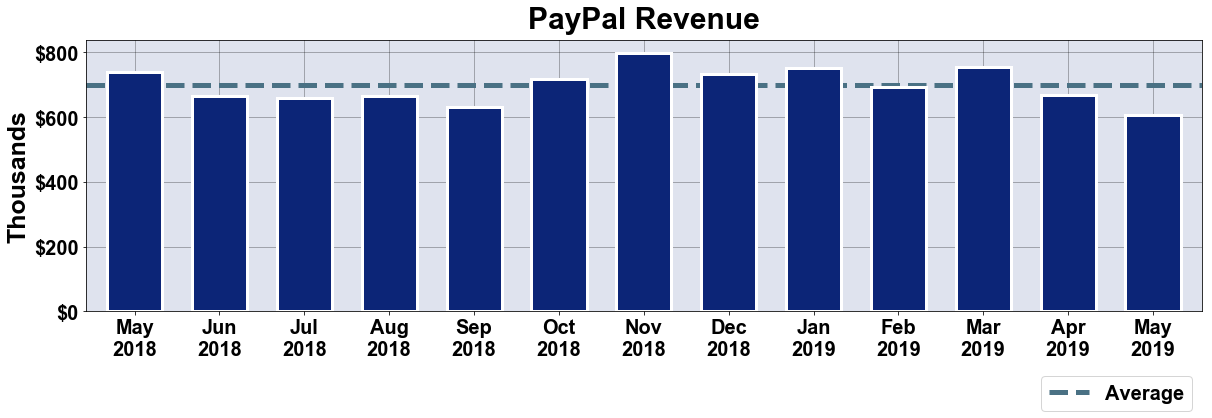

In [41]:
fig, ax = plt.subplots(figsize = (20,5))

revenue['total'].plot(kind = 'bar',
                width = 0.65,
                color = colors[0],
                edgecolor = 'white',
                lw = 3,
                label = 'Total',
                zorder = 5)

ax.axhline(revenue['total'].mean(), color = colors[1], ls = '--', label = 'Average')

ax.set_title('PayPal Revenue', y = 1.02)
ax.set_xlabel('')
ax.set_yticklabels(['${:,.0f}'.format(x/1000) for x in ax.get_yticks()])
ax.set_ylabel('Thousands')
ax.set_xticklabels(pretty_dates, rotation = 0)
ax.set_facecolor(fc)
ax.grid(color = 'black', alpha = 0.35, zorder = 0)
ax.legend(['Average'], bbox_to_anchor = (1, -0.2))

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

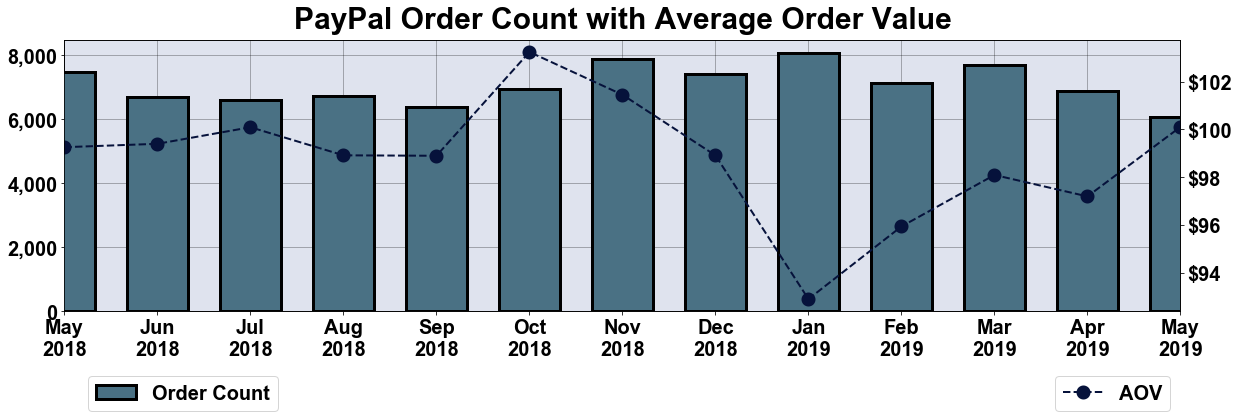

In [42]:
fig, ax = plt.subplots(figsize = (20,5))

revenue['customer OID count'].plot(kind = 'bar',
                              width = 0.65,
                              lw = 3,
                              color = colors[1],
                              edgecolor = 'black',
                              zorder = 5)

ax.set_title('PayPal Order Count with Average Order Value', y = 1.02)
ax.set_xlabel('')
ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])
ax.set_facecolor(fc)
ax.legend(['Order Count'], bbox_to_anchor = (0.2, -0.2))

ax2 = ax.twinx()
revenue['avg order value'].plot(color = colors[3], lw = 2, ls = '--', marker = 'o', mew = 8)
ax2.set_yticklabels(['${:,.0f}'.format(x) for x in ax2.get_yticks()])
ax2.legend(['AOV'], bbox_to_anchor = (1, -0.2))
ax.set_xticklabels(pretty_dates, rotation = 0)
ax.grid(color = 'black', alpha = 0.35, zorder = 0)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Fees

In [43]:
df = summary[['amount received','fees','refunded fees']].copy()
df['fees'] = df['fees'] * -1
df['fees as % of amount received'] = df['fees']/df['amount received']

fees = df.copy()

fmt = ['m2'] * 3 + ['p1']
display(jb_mean(fees, fmt))
fees.format_(fmt)

,mean
Amount Received,"$699,042.97"
Fees,"$17,149.12"
Refunded Fees,$277.53
Fees As % Of Amount Received,2.5%


,Amount Received,Fees,Refunded Fees,Fees As % Of Amount Received
year and month payment pst,,,,
2018-05,"$740,621.12","$18,431.08",$295.46,2.5%
2018-06,"$666,432.20","$16,481.01",$395.15,2.5%
2018-07,"$660,199.32","$16,244.03",$284.34,2.5%
2018-08,"$665,967.76","$16,518.46",$210.21,2.5%
2018-09,"$631,989.70","$15,600.21",$245.37,2.5%
2018-10,"$718,252.16","$17,684.13",$159.85,2.5%
2018-11,"$799,022.22","$19,659.24",$613.58,2.5%
2018-12,"$733,284.62","$17,861.28",$293.11,2.4%
2019-01,"$750,396.88","$18,327.98",$230.00,2.4%


### For report: fees

In [44]:
a = fees.iloc[-1]['fees']
b = fees.iloc[-1]['fees as % of amount received']
c = fees['fees as % of amount received'].mean()

if np.abs(b-c) < 0.02:
    res = 'in-line with'
else:
    if b < c:
        res = 'below'
    else:
        res = 'above'

w1 = 'The total fee amount hit ${:,.0f}, or {:,.1f}% of PayPal revenue, which is {} the monthly average of {:,.1f}%.'.format(a,
                                                                                                                             b * 100,
                                                                                                                             res,
                                                                                                                             c * 100)
report_dict['fees write'] = w1
report_dict['fees write']

'The total fee amount hit $14,800, or 2.4% of PayPal revenue, which is in-line with the monthly average of 2.5%.'

### Refunds

In [45]:
refunds['amount refunded'] = refunds['amount refunded'] * - 1
refunds['avg amount refunded'] = refunds['amount refunded']/refunds['refunds sent']

fmt = ['n0','m2','m2','m2']

m = jb_mean(refunds, fmt)
yoy = jb_yoy(refunds)
display(m.join(yoy))
refunds.format_(fmt).replace('nan%','')

,mean,yoy
Refunds Sent,113,-5.41%
Amount Refunded,"$12,141.36",-47.64%
Refunded Fees,$277.53,-50.29%
Avg Amount Refunded,$108.28,-44.65%


,Refunds Sent,Amount Refunded,Refunded Fees,Avg Amount Refunded
year and month payment pst,,,,
2018-05,111,"$12,242.05",$295.46,$110.29
2018-06,82,"$15,963.23",$395.15,$194.67
2018-07,97,"$11,486.06",$284.34,$118.41
2018-08,110,"$9,205.17",$210.21,$83.68
2018-09,101,"$10,633.22",$245.37,$105.28
2018-10,128,"$7,876.56",$159.85,$61.54
2018-11,133,"$28,343.48",$613.58,$213.11
2018-12,122,"$13,373.59",$293.11,$109.62
2019-01,131,"$10,199.35",$230.00,$77.86


### For report: total refund amount

In [46]:
a = refunds.iloc[-1]['amount refunded']
b = refunds.iloc[0]['amount refunded']
c = a/b-1

w1 = 'The total amount refunded {} {:,.1f}% year over year, {} from ${:,.0f} to ${:,.0f}.'.format('decreased' if c < 0 else 'increased',
                                                                                                 np.abs(c) * 100,
                                                                                                 'down' if c < 0 else 'up',
                                                                                                 b,
                                                                                                 a)
d = (refunds['amount refunded']).mean()
w2 = 'This total refund amount is {} the monthly average of ${:,.0f}.'.format('below' if a < d else 'above',
                                                                              d)

write = ' '.join([w1,w2])
report_dict['total refund write'] = write
report_dict['total refund write']

'The total amount refunded decreased 47.6% year over year, down from $12,242 to $6,410. This total refund amount is below the monthly average of $12,141.'

### For report: avg refund amount

In [47]:
a = refunds.iloc[-1]['avg amount refunded']
b = refunds.iloc[0]['avg amount refunded']
c = a/b-1

w1 = 'The average amount refunded {} {:,.1f}% year over, {} from ${:,.2f} to ${:,.2f}.'.format('fell' if c < 0 else 'rose',
                                                                                              np.abs(c) * 100,
                                                                                              'down' if c < 0 else 'up',
                                                                                              b,
                                                                                              a)
report_dict['avg refund write'] = w1
report_dict['avg refund write']

'The average amount refunded fell 44.7% year over, down from $110.29 to $61.04.'

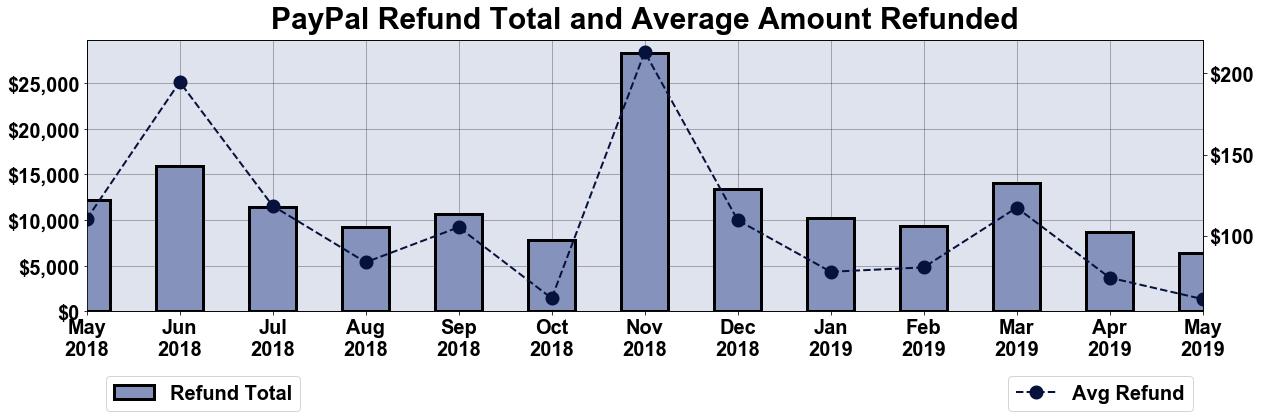

In [48]:
fig, ax = plt.subplots(figsize = (20,5))

refunds[['amount refunded']].plot(kind = 'bar',
                             ax = ax,
                             color = colors[2],
                             lw = 3,
                             edgecolor = 'black',
                             zorder = 5)

ax.set_title('PayPal Refund Total and Average Amount Refunded', y = 1.02)
ax.set_xlabel('')
ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()])
ax.set_xticklabels(pretty_dates, rotation = 0)
ax.set_facecolor(fc)
ax.legend(['Refund Total'], bbox_to_anchor = (0.2, -0.2))

ax2 = ax.twinx()
refunds[['avg amount refunded']].plot(color = colors[3], lw = 2, ls = '--', marker = 'o', mew = 8, ax = ax2)
ax2.set_yticklabels(['${:,.0f}'.format(x) for x in ax2.get_yticks()])
ax2.legend().set_visible(False)
ax2.legend(['Avg Refund'], bbox_to_anchor = (1, -0.2))
ax.set_xticklabels(pretty_dates, rotation = 0)
ax.grid(color = 'black', alpha = 0.35, zorder = 0)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Refunds for current month
See "CSP Monthly Chargeback/Fraud Report" for more on orders_statues
* Fraud - Void = stopped
* Fraud - Confirmed = not stopped

In [49]:
now = refunds_super_main[refunds_super_main['year and month payment pst'] == date_end[:7]].copy()
now.sort_values('csv gross', inplace = True)

ls = ['orders id','orders status name','billing status name']
for col in ls:
    now[col] = now['txn id'].map(dict(zip(pp_main['txn id'], pp_main[col])))
    
    

t1 = now['csv gross'].sum()
t2 = summary.iloc[-1]['amount refunded']

if np.abs(t1-t2) > 1:
    raise 0

print('${:,.0f} refunded during {}'.format(np.abs(t1), jb_dates(pd.Series(date_end[:7]), 'year and month pretty')[0]))

now['orders id'].fillna(0, inplace = True)
now['orders id'] = now['orders id'].map(int)

ls = ['orders id','csv gross','orders status name','billing status name']
fmt = [0,'m2',0,0]
now[ls].head(10).format_(fmt)

$6,410 refunded during May 2019


,Orders Id,Csv Gross,Orders Status Name,Billing Status Name
89129,2047886,$-629.20,voided,refunded
91299,2053446,$-334.03,voided,refunded
92168,2057739,$-313.50,fraud - void,refunded
91191,2054321,$-281.00,voided,refunded
92846,2059621,$-202.06,voided,refunded
91134,2047363,$-147.90,return,refunded
90746,2052922,$-145.44,voided,refunded
93363,2034845,$-145.00,return,refunded
90947,2053639,$-133.91,voided,refunded
90781,2052971,$-130.97,voided,refunded


### For report: current refunds

In [50]:
oids = now.iloc[:3]['orders id'].tolist()
totals = now.iloc[:3]['csv gross'].tolist()
totals = [np.abs(x) for x in totals]

link = 'https://volcano.adafruit.com/volcano/Order_Status.php?oid='

for i in range(3):
    report_dict['refund oid ' + str(i)] = str(oids[i])
    report_dict['refund link ' + str(i)] = link + str(oids[i])
    report_dict['refund amount ' + str(i)] = '${:,.0f}'.format(totals[i])

### Chargebacks and Reversals

In [51]:
main = other_debits_main[other_debits_main['type'].isin(['payment reversal','chargeback'])].copy()
df1 = main.groupby(['year and month payment pst','type'])[['csv gross']].sum().unstack(1)
df1.columns = df1.columns.droplevel(0)

df2 = ym.join(df1).fillna(0)

df2.format_(['m0'] * 2)

,Chargeback,Payment Reversal
year and month,,
2018-05,$0,$-30
2018-06,$-97,$-145
2018-07,$0,$-163
2018-08,$-209,$0
2018-09,$0,$0
2018-10,$0,$0
2018-11,$-624,$0
2018-12,$0,$0
2019-01,$0,$-11


### Payment types by count

In [52]:
pay = pd.read_sql(
'''
SELECT
DATE_FORMAT(date_purchased, '%Y-%m') AS year_and_month,
payment_method
FROM orders
WHERE DATE(date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND orders_status NOT IN (9,11,12,13,14,15)
''', db)

col_fix(pay)

In [53]:
pay['payment method'] = np.where(pay['payment method'].str.contains('Purchase Order'), 'Purchase Order', pay['payment method'])

pay2 = pay.groupby(['year and month','payment method'])[['payment method']].count().unstack(1).fillna(0)
pay2.columns = pay2.columns.get_level_values(1)
pay2.sort_values(pay2.index[-1], 
                 ascending = False, 
                 axis = 1,
                 inplace = True)

pay3 = pay2.iloc[[-1]].T

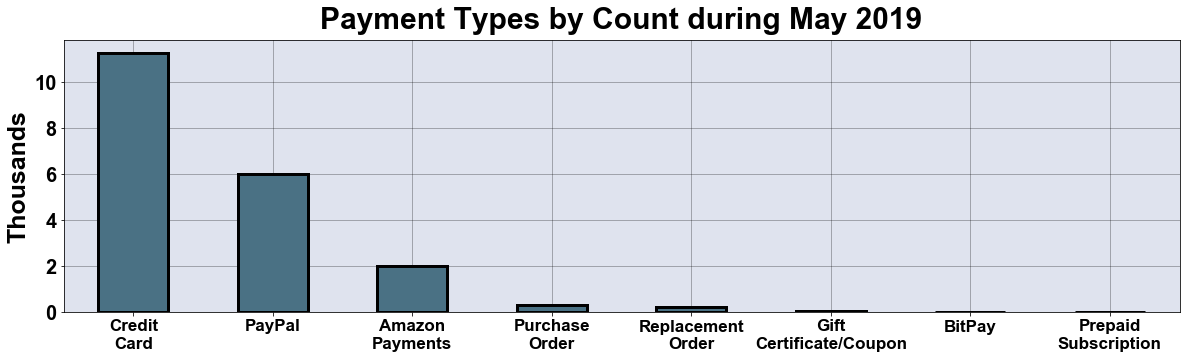

In [54]:
fig, ax = plt.subplots(figsize = (20,5))

xticks = pay3.index
xticks = [x.replace(' ','\n') for x in xticks]

d = date_end
m = calendar.month_abbr[int(d[5:7])]
y = d[:4]
d2 = m + ' ' + y

pay3.plot(kind = 'bar', 
          ax = ax, 
          edgecolor = 'black',
          color = colors[1], 
          zorder = 5,
          lw = 3)

ax.set_yticklabels(['{:,.0f}'.format(x/1000) for x in ax.get_yticks()])
ax.set_ylabel('Thousands')
ax.set_xticklabels(xticks, rotation = 0, fontsize = 17)
ax.set_xlabel('')
ax.set_title('Payment Types by Count during %s' % d2, y = 1.02)
ax.set_facecolor(fc)
ax.legend().set_visible(False)
ax.grid(color = 'black', alpha = 0.35, zorder = 0)

plt.savefig(image_path + ax.get_title()[:22], bbox_inches = 'tight')
plt.show()

### For report: rank

In [55]:
rank = pay3.index.get_loc('PayPal') + 1

if rank == 1:
    ret = 'first'
elif rank == 2:
    ret = 'second'
elif rank == 3:
    ret = 'third'
elif rank == 4:
    ret = 'fourth'
elif rank == 5:
    ret = 'fifth'    
    
report_dict['rank'] = ret
report_dict['rank']

'second'

### PDF report

In [56]:
year_and_month = calendar.month_abbr[int(date_end[5:7])] + ' ' + date_end[:4]
report_title = date_end[:4] + ' - ' + date_end[5:7] + ' - ' + calendar.month_abbr[int(date_end[5:7])] + ' - PayPal Monthly Audit'

### For report: summary

In [57]:
a = revenue['total'].pct_change(periods = 12).iloc[-1]
w1 = 'PayPal revenue {} {:,.0f}% year over year;'.format('decreased' if a < 0 else 'increased',
                                                        np.abs(a) * 100)

a = revenue['avg order value'].pct_change(periods = 12).iloc[-1]
if a < 0.01:
    res = 'remained the same'
else:
    if a < 0:
        res = 'fell {:,.0f}%'.format(np.abs(a) * 100)
    else:
        res = 'rose {:,.0f}%'.format(np.abs(a) * 100)
w2 = 'the average order value {} year over year;'.format(res)
a = fees.iloc[-1]['fees as % of amount received']
b = fees['fees as % of amount received'].mean()

if np.abs(a-b) < 0.02:
    res = 'in-line with'
else:
    if a < b:
        res = 'less than'
    else:
        res = 'greater than'
    
w3 = 'fees were {} past months;'.format(res)

a = refunds['amount refunded'].pct_change(periods = 12).iloc[-1]
w4 = 'total amount refunded was {} {:,.0f}% year over year;'.format('down' if a < 0 else 'up',
                                                                   np.abs(a) * 100)

a = refunds['avg amount refunded'].pct_change(periods = 12).iloc[-1]
w5 = 'average amount refunded was {} {:,.0f}% year over year;'.format('down' if a < 0 else 'up',
                                                                       np.abs(a) * 100)

a = revenue.iloc[-1]['paypal total as % of monthly total']
w6 = 'PayPal revenue made up {:,.0f}% of total monthly revenue.'.format(a * 100)

write = ' '.join([w1,w2,w3,w4,w5,w6])
report_dict['summary write'] = write
report_dict['summary write']

'PayPal revenue decreased 18% year over year; the average order value remained the same year over year; fees were in-line with past months; total amount refunded was down 48% year over year; average amount refunded was down 45% year over year; PayPal revenue made up 18% of total monthly revenue.'

# PDF Start

In [58]:
if write_pdf == 'yes':
    
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'year_and_month':year_and_month,
                     'now':now_pretty,
                     'summary_write':report_dict['summary write'],
                     'revenue_write':report_dict['revenue write'],
                     'proportion_write':report_dict['proportion write'],
                     'aov_write':report_dict['aov write'],
                     'fees_write':report_dict['fees write'],
                     'total_refund_write':report_dict['total refund write'],
                     'avg_refund_write':report_dict['avg refund write'],
                     
                     'refund_link_0':report_dict['refund link 0'],
                     'refund_link_1':report_dict['refund link 1'],
                     'refund_link_2':report_dict['refund link 2'],
                    
                     'refund_oid_0':report_dict['refund oid 0'],
                     'refund_oid_1':report_dict['refund oid 1'],
                     'refund_oid_2':report_dict['refund oid 2'],
                    
                     'refund_amount_0':report_dict['refund amount 0'],
                     'refund_amount_1':report_dict['refund amount 1'],
                     'refund_amount_2':report_dict['refund amount 2'],
                     
                     'rank':report_dict['rank'],
                    
                     'tilde':tilde}

    html_out = template.render(template_vars)

    from weasyprint import HTML

    HTML(string = html_out).write_pdf(pdf_path + report_title + '.pdf',
                                      stylesheets = [style_sheet_path])                               

In [59]:
print('done')

done
